### Provide by

นายธนชาติ เสถียรจารุการ 63340500021 <br>

นายพชพล เพชรรัตน์ 63340500036 <br>

นายพร้อม

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

RandomState = 1
match_df = pd.read_csv('match.csv')
match_df = match_df.drop(['start_time','game_mode', 'negative_votes', 'positive_votes', 'cluster'], axis=1)
match_df['radiant_win'] = match_df['radiant_win'].replace([False, True], [0, 1])

##### explore match dataframe

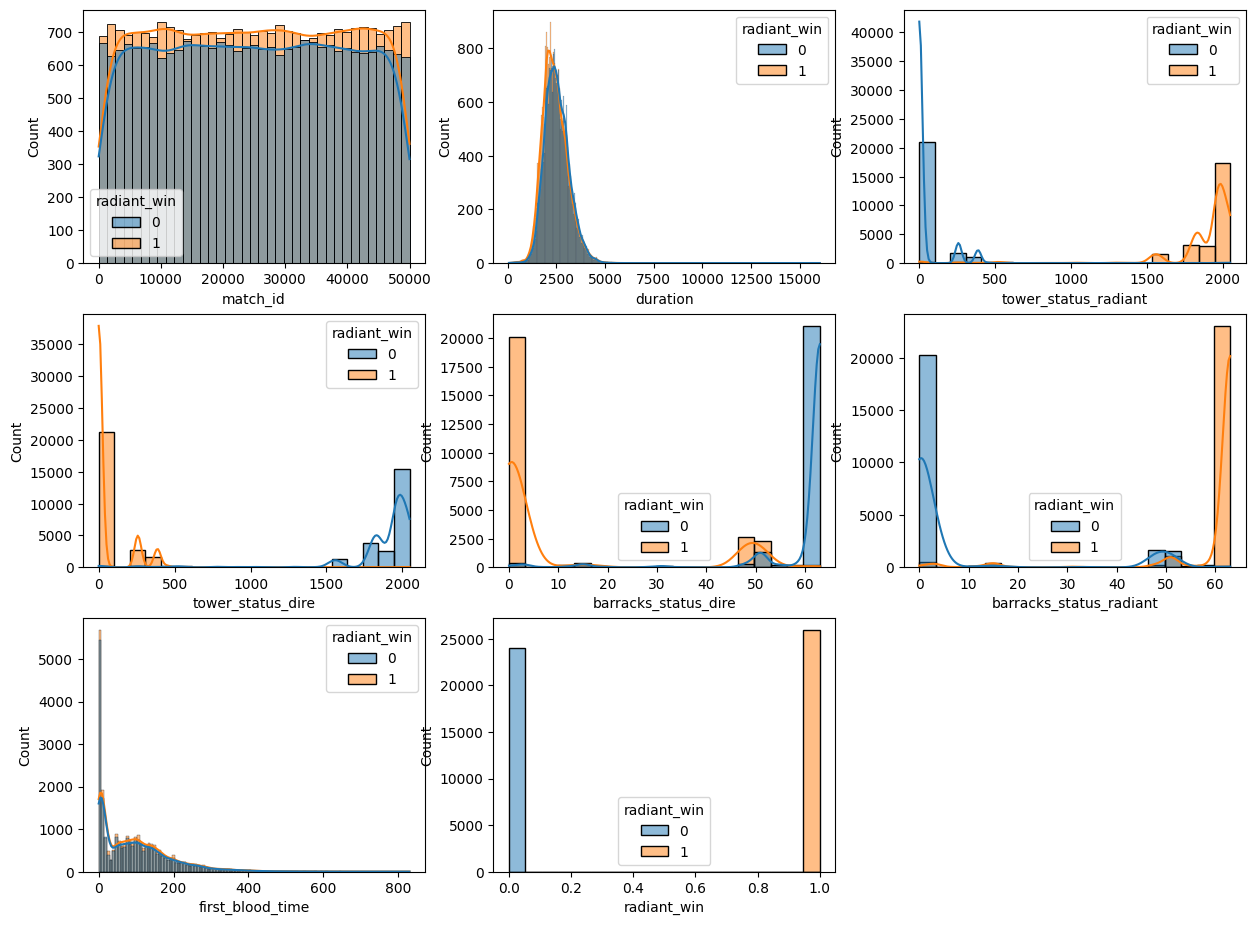

In [2]:
cols = match_df.columns
plot_num = 1
plt.figure(figsize = (15,27))
for i in cols:
    ax = plt.subplot(7, 3, plot_num)
    sns.histplot(data=match_df, x=i, kde=True, hue='radiant_win')
    plot_num += 1
plt.show()

##### explore player dataframe

In [5]:
player_df = pd.read_csv('players.csv')
player_df = player_df.iloc[:, 0:25]
player_df = player_df.drop(['gold', 'account_id', 'item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5'], axis=1)
player_df['stuns'] = player_df['stuns'].replace(['None'], [0.0])
player_df['stuns'] = player_df['stuns'].astype(np.float64)
player_df['leaver_status'] = player_df['leaver_status'].replace(list(range(5)), [0, 0, 1, 1, 1])
player_df.head()

,match_id,hero_id,player_slot,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,level,leaver_status
0,0,86,0,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,16,0
1,0,51,1,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,22,0
2,0,83,2,12195,350,385,0,4,15,1,58,0.0000,4217,1595,399,17,0
3,0,11,3,22505,599,605,8,4,19,6,271,0.0000,14832,2714,6055,21,0
4,0,67,4,23825,613,762,20,3,17,13,245,0.0000,33740,243,1833,24,0


- sum of feature values of each team

In [10]:
cols = list(player_df.columns)
cols = [i for i in cols if i!='match_id' and i!='hero_id' and i!='player_slot']
cols

['gold_spent',
 'gold_per_min',
 'xp_per_min',
 'kills',
 'deaths',
 'assists',
 'denies',
 'last_hits',
 'stuns',
 'hero_damage',
 'hero_healing',
 'tower_damage',
 'level',
 'leaver_status']

In [14]:
cols = list(player_df.columns)
cols = [i for i in cols if i!='match_id' and i!='hero_id' and i!='player_slot']
sum_data = {}
index = []
for j in cols:
    sum_data.update({'radiant_total_'+str(j):[],
                        'dire_total_'+str(j):[]})
for i in tqdm(range(match_df.shape[0])):
    a = player_df.loc[player_df['match_id']==i]
    radiant = a.loc[a['player_slot']<=4]
    dire = a.loc[a['player_slot']>4]
    index.append(i)
    for j in cols:
        sum_data['radiant_total_'+str(j)].append(radiant[j].sum())
        sum_data['dire_total_'+str(j)].append(dire[j].sum())


100%|██████████| 50000/50000 [02:37<00:00, 316.59it/s]


- merge two dataframe

100%|██████████| 36/36 [00:13<00:00,  2.74it/s]


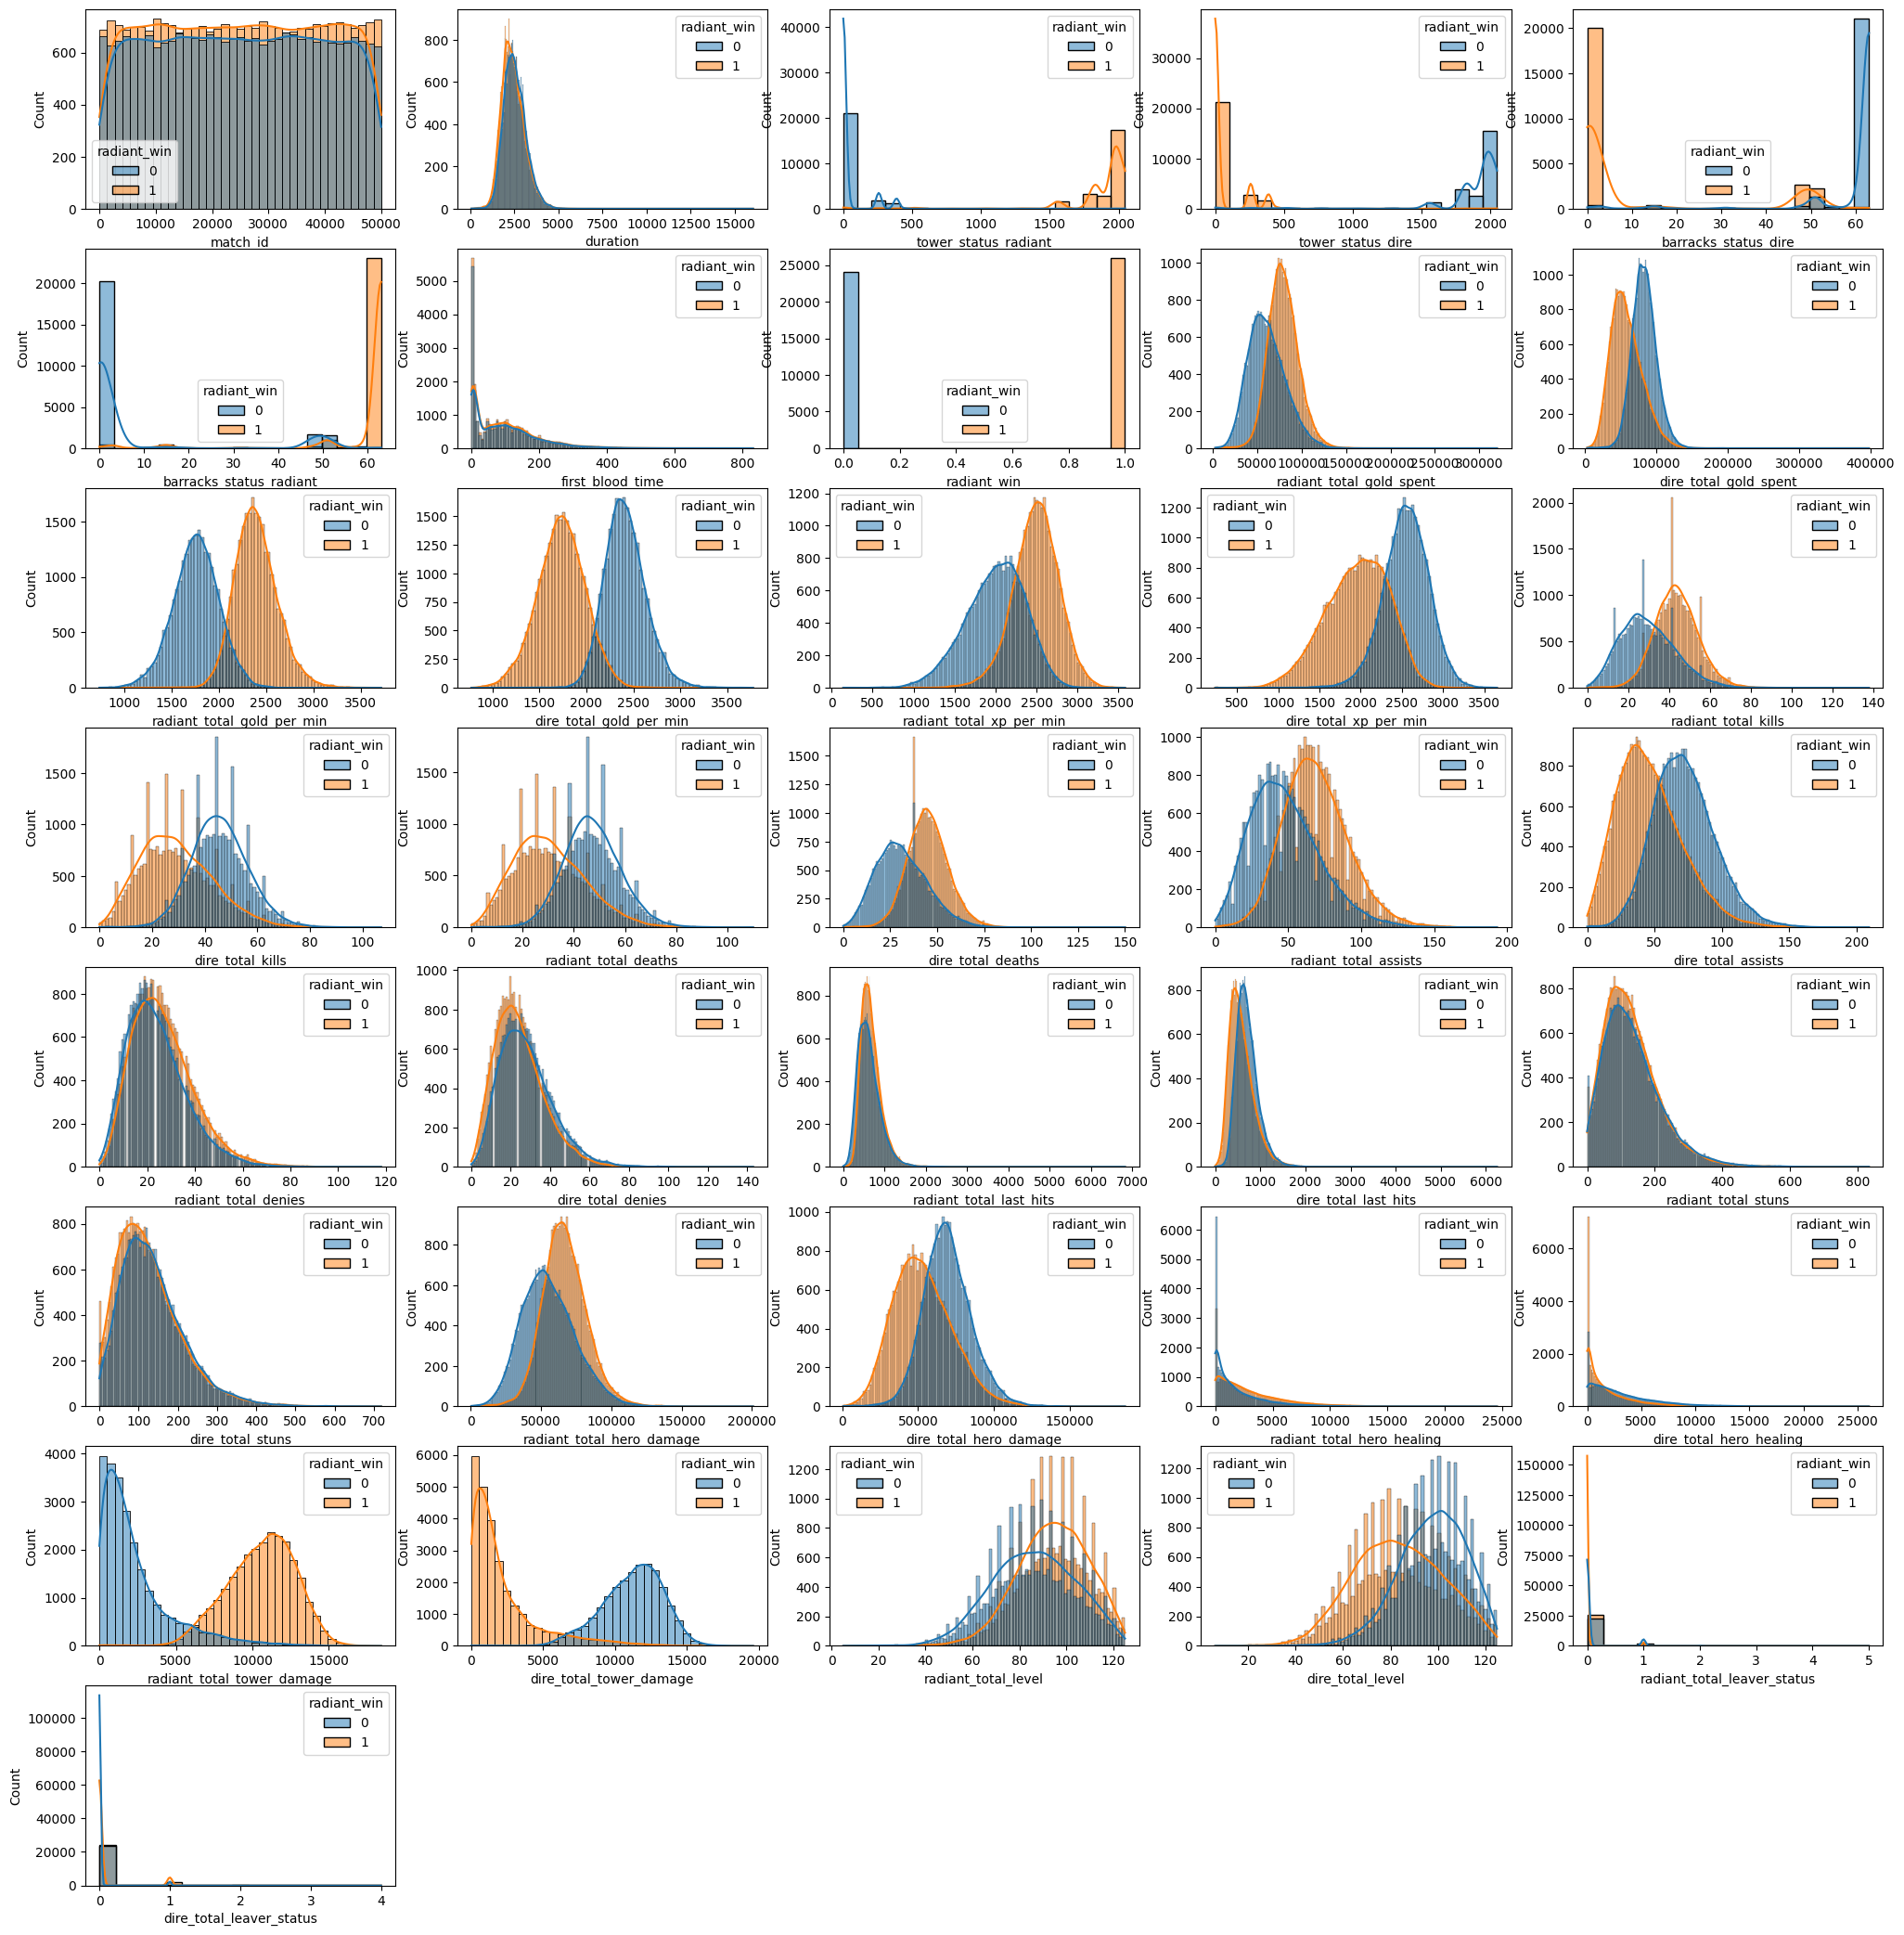

In [15]:
total_df = pd.DataFrame(data=sum_data, index=index)
new_df = pd.concat([match_df, total_df], axis=1)
cols = new_df.columns
# new_df.to_csv("new_match_df.csv")
plot_num = 1
plt.figure(figsize = (25,100))
for i in tqdm(cols):
    ax = plt.subplot(30, 5, plot_num)
    sns.histplot(data=new_df, x=i, kde=True, hue='radiant_win')
    plot_num += 1
plt.show()

- what is the most hero picked?

In [ ]:
sns.histplot(data=player_df, x='hero_id')
plt.show()
print(player_df['hero_id'].value_counts())

##### explore team fight dataframe

In [18]:
teamfight_df = pd.read_csv('teamfights.csv')
teamfight_df.head()

,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5


##### explore team fight player dataframe

In [19]:
teamfight_player_df = pd.read_csv('teamfights_players.csv')
teamfight_player_df = teamfight_player_df.rename(columns={'gold_delta': 'delta_gold'})
teamfight_player_df['delta_xp'] = teamfight_player_df['xp_end']-teamfight_player_df['xp_start']
teamfight_player_df.head()

,match_id,player_slot,buybacks,damage,deaths,delta_gold,xp_end,xp_start,delta_xp
0,0,0,0,105,0,173,536,314,222
1,0,1,0,566,1,0,1583,1418,165
2,0,2,0,0,0,0,391,391,0
3,0,3,0,0,0,123,1775,1419,356
4,0,4,0,444,0,336,1267,983,284


In [ ]:
feature_list = ['delta_gold', 'delta_xp']
itertime = 0
sum_data = {}
index = []
for i in feature_list:
    sum_data.update({'radiant_total_'+str(i):[],
                        'dire_total_'+str(i):[]})
for i in tqdm(range(match_df.shape[0])):
    select_match = teamfight_player_df.loc[teamfight_player_df['match_id']==i]
    fight_num = int((select_match.shape[0])/10)
    for j in range(fight_num):
        index.append(itertime)
        one_teamfight = select_match.iloc[(10*j):(10*(j+1)),:]
        radiant = one_teamfight.loc[one_teamfight['player_slot']<=4]
        dire = one_teamfight.loc[one_teamfight['player_slot']>4]
        for k in feature_list:
            sum_data['radiant_total_'+str(k)].append(radiant[k].sum())
            sum_data['dire_total_'+str(k)].append(dire[k].sum())
        itertime += 1

In [ ]:
teamfight_time = teamfight_df[['match_id', 'start', 'end']]
teamfight_time.shape

In [ ]:
sum_teamfight_df = pd.DataFrame(data=sum_data, index=index)
new_teamfight_df = pd.concat([teamfight_time, sum_teamfight_df], axis=1)
new_teamfight_df.head()

In [ ]:
from multiprocessing import Pool
from src.manage_df import extactTeamfightDataframe
from functools import partial

if __name__ ==  '__main__':
    with Pool(processes=32) as p:
        output = p.map(extactTeamfightDataframe, [teamfight_player_df.loc[teamfight_player_df['match_id']==i] for i in range(match_df.shape[0])])
        p.close()
        p.join()
        print('finish')
    feature_list = ['delta_gold', 'delta_xp']
    sum_data = {}
    for i in feature_list:
        sum_data.update({'radiant_total_'+str(i):[],
                            'dire_total_'+str(i):[]})

    for i in tqdm(range(len(output))):
        for k in feature_list:
            sum_data['radiant_total_'+str(k)] = sum_data['radiant_total_'+str(k)] + (output[i]['radiant_total_'+str(k)])
            sum_data['dire_total_'+str(k)] = sum_data['dire_total_'+str(k)] + (output[i]['radiant_total_'+str(k)])


##### explore player time dataframe

In [ ]:
player_time_df = pd.read_csv('player_time.csv')
player_time_df.head()

In [ ]:
test = player_time_df.loc[player_time_df['match_id']==0]
fig, ax = plt.subplots(figsize=(8, 3))
for i in range(5):
    ax.scatter(test['times'], test['gold_t_'+str(i)], label='player'+str(i), c='r', s=5)
    ax.plot(test['times'], test['gold_t_'+str(i)], c='r')
for i in range(128,133,1):
    ax.scatter(test['times'], test['gold_t_'+str(i)], label='player'+str(i), c='b', s=5)
    ax.plot(test['times'], test['gold_t_'+str(i)], c='b')
ax.set_xlabel("times")
ax.set_ylabel("gold")
plt.legend(loc='upper left')
plt.show()